# A Recurrent Network Mechanism of Time Integration in Perceptual Decisions
Wong,  Wang
Journal of Neuroscience, January 2006, 26(4):1212-1328

## Material and Methods
### The two-variable network model

### Calling Library Fuctions

In [1]:
# LIBRARY

import numpy as np # vector manipulation
import math  # math functions
import sys

# THIS IS FOR PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import warnings
warnings.filterwarnings("ignore")


### The Reduced Network Model

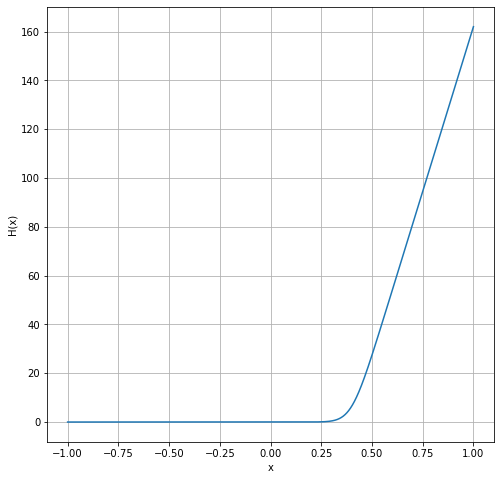

In [2]:
def H(x):
    a=270
    b=108
    d=0.154
    f=(a*x-b)/(1-np.exp(-d*(a*x-b)))
    return f

x=np.arange(-1,1,0.0001)
fig = plt.figure(figsize=(8,8))
plt.plot(x,H(x))
plt.grid()
plt.xlabel('x')
plt.ylabel('H(x)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



### Neural Circuit
$$ x_{1}=J_{11}S_1-J_{12}S_2+I_{0}+I_{1}+I_{noise,1}$$
$$ x_{2}=J_{22}S_2-J_{21}S_1+I_{0}+I_{2}+I_{noise,1}$$

where the synaptic couplings are $J_{11}=0.2609$, $J_{22}=0.2609$, $J_{12}=0.0497$ and $J_{21}=0.0497$.
$I_{0}=0.3255 nA$ represents external input 


In [3]:
def total_synaptic_current(S_1,S_2,I_1,I_2,I_noise_1,I_noise_2):
    # Synaptic coupling
    J_22=J_11=0.2609 # nA
    J_21=J_12=0.0497 # nA
    I_0=0.3255  # nA
    x_1=J_11*S_1-J_12*S_2+I_0+I_1+I_noise_1
    x_2=J_22*S_2-J_21*S_1+I_0+I_2+I_noise_2
    return x_1, x_2


### Background activity
$$ \tau_{AMPA}\frac{d I_{noise,i}(t)}{dt} =-I_{noise,i}(t)+\eta_i(t)\sqrt{\tau_{AMPA}}\sigma_{noise}$$

In [4]:
def Background_Activity(I_noise,h):
    sigma_noise=0.02 # nA
    tau_AMPA=2/1000#ms
    eta_noise=np.random.normal(0,1,1)
    I_0=0.0#3255  # nA
    I_noise_new=I_noise+(h/1000)/tau_AMPA*(-(I_noise-I_0)+eta_noise*np.sqrt(tau_AMPA)*sigma_noise)
    return I_noise_new

### Network Dynamics
$$ \frac{d S_{i}}{dt} =-\frac{S_{i}}{\tau_S}+(1-S_{i})\gamma H_{i}$$

In [5]:
def Network_Dynamics_old(S,x,h):
    h1=0.1/1000 #ms
    gamma=0.641
    tau_S=100/1000 #s
    k=(-S/tau_S+(1-S)*gamma*H(x))
    S_new=S+h1*(-(S+h/2*k)/tau_S+(1-S+h1/2*k)*gamma*H(x))
    return S_new
def Network_Dynamics(S,x,h):
    tau_S=100/1000#100 #ms
    𝛾=0.641
    S_new=S+h/1000*((-S/tau_S)+(1-S)*𝛾*H(x))
    return S_new

### Input Current Target

$$ I_i=J_{A,ext}\mu_0\left(1+ \frac{c'}{100} \right) $$


In [6]:
def I_input_1(c_dash):
    J_A_ext=5.2/10000# nA/Hz
    mu_0=30 # Hz
    f=1
    I_motion=J_A_ext*mu_0*(1+f*(c_dash)/100)
    return I_motion

$$ I_2=J_{A,ext}\mu_0\left(1- \frac{c'}{100} \right) $$

In [7]:
def I_input_2(c_dash):
    J_A_ext=5.2*10**-4# nA/Hz
    mu_0=30 # Hz
    f=1.0
    p=0
    I_motion=J_A_ext*mu_0*(1-f*(c_dash+p)/100)
    return I_motion

In [8]:
h=0.1
time=np.arange(-100,1200,h)
J_A_ext=5.2/10000 # nA/Hz
mu_0=30 # Hz
Vector_coherence=[0.5,1,2,3, 5,10,20.0]#0.5,2.5,5,7.5,10,15]

Threshold=15
N=501
RT_coh_hit=np.zeros(len(Vector_coherence))
RT_coh_miss=np.zeros(len(Vector_coherence))
Prob=np.zeros(len(Vector_coherence))
count=0
#fig = plt.figure(figsize=(12,8))

ALL_F_1=0.2*np.ones((N,len(time)))
ALL_F_2=0.2*np.ones((N,len(time)))
I_1=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
I_2=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
Firing_target_1=0*time # np.zeros((1,len(time)))
Firing_target_2=0*time # np.zeros((1,len(time)))

In [9]:
for j in range(0,len(Vector_coherence)): # COHERENCE
    print("Coherence: ",Vector_coherence[j])
    ANSWER=np.zeros(N)
    RT=np.zeros(N)


    for n in range(0,N): # TRIAL LOOP
        if n%100==0:
            print("Trial Number: ",n)
        I_noise_1=np.random.uniform(0,0.01,len(time))#0.004*np.random.normal(0,1,len(time))   # initalise noisy input as normal distribution
        I_noise_2=np.random.uniform(0,0.01,len(time))#0.004*np.random.normal(0,1,len(time))   # why multiply by 0.004? Or how to know to do this  ?


        x_1=J_A_ext*mu_0*np.ones(len(time))
        x_2=J_A_ext*mu_0*np.ones(len(time))

        S_1=0.2+np.random.uniform(0,0.01,len(time))#0.1*np.random.uniform(0,1,len(time))# np.random.normal(0,1,len(time))*0.0004
        S_2=0.2+np.random.uniform(0,0.01,len(time)) #0.1*np.random.uniform(0,1,len(time)) #np.random.normal(0,1,len(time))*0.0004

        Firing_target_1[0]=H(S_1[0])
        Firing_target_2[0]=H(S_2[0])


        Decision=False
        for i in range (0,len(time)-1):
            if time[i] >=0 and time[i]<1000:
                c_dash=Vector_coherence[j]
            else:
                c_dash=0.0

        
            I_noise_1[i+1]=Background_Activity(I_noise_1[i],h)
            I_noise_2[i+1]=Background_Activity(I_noise_2[i],h)

            I_1[i+1]=I_input_1(c_dash)
            I_2[i+1]=I_input_1(-c_dash)

            S_1[i+1]=Network_Dynamics(S_1[i],x_1[i],h)
            S_2[i+1]=Network_Dynamics(S_2[i],x_2[i],h)
            x_1[i+1],x_2[i+1]=total_synaptic_current(S_1[i],S_2[i],I_1[i],
                                                     I_2[i],I_noise_1[i],I_noise_2[i])

            Firing_target_1[i+1]=H(x_1[i+1])
            Firing_target_2[i+1]=H(x_2[i+1])
           # ALL_F_1[n,i]=Firing_target_1[i]

            if (Decision==False):
                if Firing_target_1[i] >=Threshold: 
                    ANSWER[n]=1
                    RT[n]=time[i]
                    Decision=True
                elif Firing_target_2[i] >=Threshold:
                    ANSWER[n]=0
                    RT[n]=time[i]
                    count=1
                    Decision=True              

    RT_coh_hit[j]=np.average(RT[ANSWER==1])
    RT_coh_miss[j]=np.average(RT[ANSWER==0])
    Prob[j]=np.average(ANSWER)
    RT_coh_hit[j]=np.average(RT[ANSWER==1])
    RT_coh_miss[j]=np.average(RT[ANSWER==0])
    Prob[j]=np.average(ANSWER)

#plt.savefig('Wang_individual_trials.png', bbox_inches='tight',dpi=300)
#plt.show()
    

Coherence:  0.5
Trial Number:  0
Trial Number:  100
Trial Number:  200
Trial Number:  300
Trial Number:  400
Trial Number:  500
Coherence:  1
Trial Number:  0
Trial Number:  100
Trial Number:  200
Trial Number:  300
Trial Number:  400
Trial Number:  500
Coherence:  2
Trial Number:  0
Trial Number:  100
Trial Number:  200
Trial Number:  300
Trial Number:  400
Trial Number:  500
Coherence:  3
Trial Number:  0
Trial Number:  100
Trial Number:  200
Trial Number:  300
Trial Number:  400
Trial Number:  500
Coherence:  5
Trial Number:  0
Trial Number:  100
Trial Number:  200
Trial Number:  300
Trial Number:  400
Trial Number:  500
Coherence:  10
Trial Number:  0
Trial Number:  100
Trial Number:  200
Trial Number:  300
Trial Number:  400
Trial Number:  500
Coherence:  20.0
Trial Number:  0
Trial Number:  100
Trial Number:  200
Trial Number:  300
Trial Number:  400
Trial Number:  500


### Plotting
#### Input

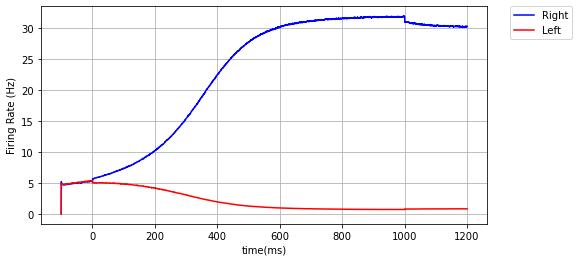

In [10]:
fig = plt.figure(figsize=(8,4))

plt.plot(time,Firing_target_1,'-',color='blue',label="Right")
plt.plot(time,Firing_target_2,'-',color='red',label="Left")
plt.grid()
plt.xlabel('time(ms)')
plt.ylabel('Firing Rate (Hz)')
#plt.xlim((-100,1000))
#plt.ylim((0,Threshold))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('Example_Firing_Pattern.png', bbox_inches='tight',dpi=300)

# plt.
#plt.ylim((30,50))
plt.show()


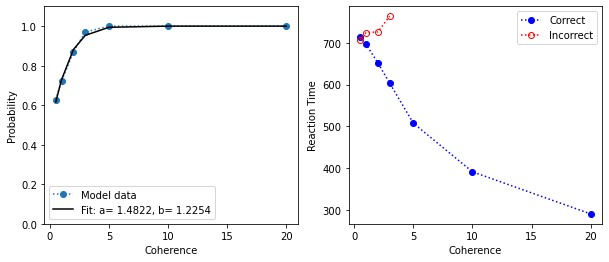

In [13]:
from scipy.optimize import curve_fit
from scipy.stats import norm
Vector_coh=np.array(Vector_coherence)


def func_temp(coh,alpha,beta):
    return 1-0.5*np.exp(-(coh/alpha)**beta)

popr, pcov=curve_fit(func_temp,Vector_coh,Prob)



fig = plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(Vector_coh,Prob,'o:',label='Model data')
plt.plot(Vector_coh,func_temp(Vector_coh,*popr),'k',label='Fit: a= %0.4f, b= %0.4f'% tuple(popr))



plt.legend()
plt.ylim((0,1.1))


plt.xlabel('Coherence')
plt.ylabel('Probability')
#plt.xscale('log')
plt.ylim(0,1.1)
plt.subplot(122)
plt.plot((Vector_coherence),RT_coh_hit,'o:',color='blue',label="Correct")
plt.plot((Vector_coherence),RT_coh_miss,'o:',fillstyle='none',color='red',label="Incorrect")
#plt.xscale('log')
plt.legend()
#plt.ylim(0,900)
plt.xlabel('Coherence')
plt.ylabel('Reaction Time')
plt.show()

In [15]:
Vector_coh.shape

(7,)

In [14]:
## Library
import numpy as np
import math 
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import matplotlib.gridspec as gridspec # subplots
import warnings
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)
from celluloid import Camera


MovieWriter Pillow unavailable; using Pillow instead.


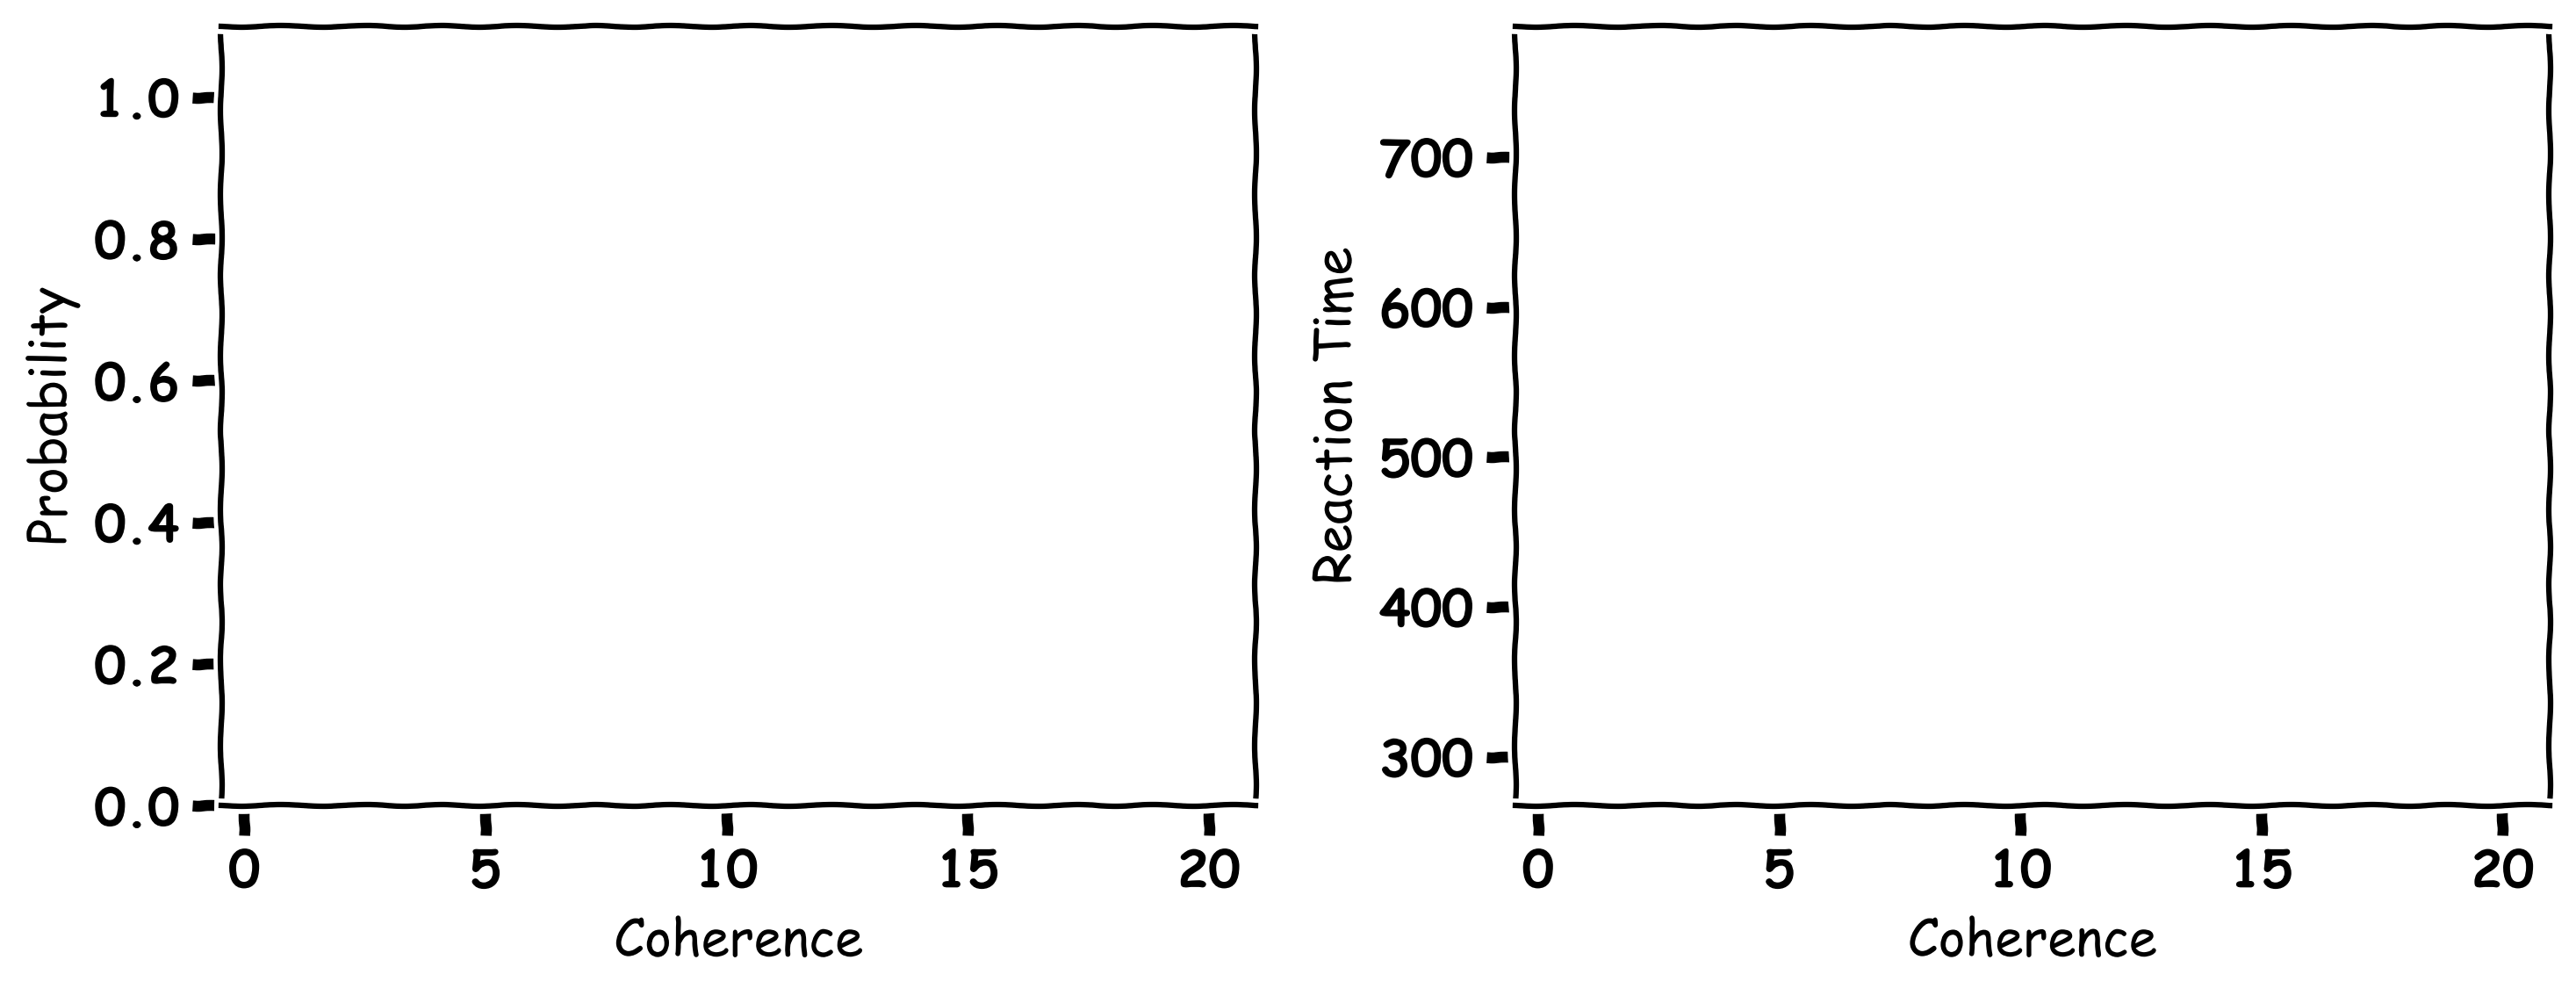

In [23]:
with plt.xkcd():

    fig = plt.figure(figsize=(10,4),dpi=300)
    camera=Camera(fig)
    for n in range(0,8): 
        plt.subplot(121)
        plt.plot(Vector_coh[0:n],Prob[0:n],'bo:',label='Model data')
        if n>6:
            plt.plot(Vector_coh,func_temp(Vector_coh,*popr),'k',label='Fit: a= %0.4f, b= %0.4f'% tuple(popr))


        if n==0:
            plt.legend()
        plt.ylim((0,1.1))


        plt.xlabel('Coherence')
        plt.ylabel('Probability')
        #plt.xscale('log')
        plt.ylim(0,1.1)
        plt.subplot(122)
        plt.plot((Vector_coherence[0:n]),RT_coh_hit[0:n],'o:',color='blue',label="Correct")
        plt.plot((Vector_coherence[0:n]),RT_coh_miss[0:n],'o:',fillstyle='none',color='red',label="Incorrect")
        #plt.xscale('log')
        if n==0:
            plt.legend()
        #plt.ylim(0,900)
        plt.xlabel('Coherence')
        plt.ylabel('Reaction Time')
        plt.tight_layout()
        
        camera.snap()
    animation = camera.animate()
    animation.save('Coherence.gif', writer='Pillow', fps=5)
    